In [ ]:
%matplotlib inline
from pathlib import Path
import glob
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, LineString
from fiona.crs import from_string
from matplotlib import pyplot as plt

### When to run this Notebook

Just after running a) Notebook 01 and b) HySpex RAD and NAV. It assumes all the output files of NAV are in one single folder. 

### Initialize variables

You should only have to change the variables in this section. Make code changes in subsequent sections only if you have special needs to adapt the code. Please enter the project directory for your processing project, and the prefix of your HySpex files. (That is, both HySpex NAV and RAD produce output files per flightline. The prefix is the string before the flightline number. For example, for the file `20200522-cal_01_SWIR_384me_SN3107_FOVx2_raw.txt` the prefix would be `20200522-cal`. Leave out the underscore. 

In [ ]:
projectdir = Path(r"Z:\fihyper\cwaigl\20210911_DC")
prefix = '20210911-DC'

By default, this script only uses the VNIR GPS data to generate the GIS file. Change this if you want one flightline for each, VNIR and SWIR.

In [ ]:
VNIR_only = True

### Check and load the gps data

In [ ]:
datadir = projectdir / r'00_aux\Software\HySpex_NAV_20200402_latest'
print(f"Data path exists: {datadir.is_dir()}")
if VNIR_only:
    datafiles = sorted(list(datadir.glob(f'{prefix}*VNIR*.txt')))
else:
    datafiles = sorted(list(datadir.glob(f'{prefix}*.txt')))
print(f"There are {len(datafiles)} files to be processed.")

Data path exists: True
There are 26 files to be processed.


(the meaning of the column is something like `header=['rowid', 'lon', 'lat', 'elev', 'roll', 'pitch', 'heading', 'timestamp', ]`)

In [ ]:
headerfields = ['rowid', 'lon', 'lat', 'elev', 'roll', 'pitch', 'heading', 'timestamp', ]
geodfs = []
for fpath in datafiles:
    datatable = pd.read_csv(fpath, sep='\s+', header=None)
    datatable.columns = headerfields
    datatable = datatable[datatable.lat > 0]
    datatable.iloc[::10, :]
    geodf = gp.GeoDataFrame(
    datatable, geometry=gp.points_from_xy(datatable.lon, datatable.lat))
    geodfs.append(geodf)

In [ ]:
geodfs[0]

,rowid,lon,lat,elev,roll,pitch,heading,timestamp,geometry
0,1,-150.498554,64.969388,2274.646596,-2.817537,-3.383573,188.389974,594217.078276,POINT (-150.49855 64.96939)
1,2,-150.498554,64.969382,2274.640953,-2.805596,-3.379071,188.393715,594217.090276,POINT (-150.49855 64.96938)
2,3,-150.498553,64.969377,2274.635638,-2.776459,-3.334469,188.391567,594217.102276,POINT (-150.49855 64.96938)
3,4,-150.498552,64.969371,2274.630368,-2.744449,-3.325957,188.394481,594217.114276,POINT (-150.49855 64.96937)
4,5,-150.498552,64.969365,2274.624872,-2.725295,-3.358503,188.390550,594217.126275,POINT (-150.49855 64.96936)
...,...,...,...,...,...,...,...,...,...
23658,23659,-150.500947,64.827107,2252.978378,-2.042293,-4.238844,188.772727,594500.969484,POINT (-150.50095 64.82711)
23659,23660,-150.500947,64.827101,2252.966792,-2.045754,-4.207064,188.770981,594500.981483,POINT (-150.50095 64.82710)
23660,23661,-150.500947,64.827095,2252.955047,-2.043833,-4.218023,188.764907,594500.993483,POINT (-150.50095 64.82709)
23661,23662,-150.500948,64.827089,2252.943002,-2.062213,-4.256115,188.760812,594501.005483,POINT (-150.50095 64.82709)


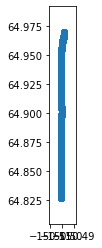

In [ ]:
geodfs[0].plot()

In [ ]:
flightlines = [LineString(geodf['geometry'].tolist()) for geodf in geodfs] 
flightseries = gp.GeoSeries(flightlines[1:])

In [ ]:
startpoints = [(flightline.boundary[0].x, flightline.boundary[0].y) for flightline in flightseries]

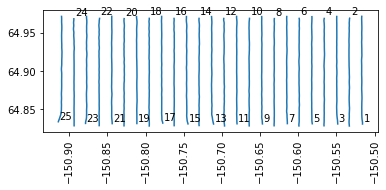

In [ ]:
ax = flightseries.plot()
plt.xticks(rotation=90)
for idx, (x, y) in enumerate(startpoints):
    ax.annotate(str(idx+1), xy=(x, y), xytext=(1, 3), textcoords="offset points")

In [ ]:
wgs84_crs = from_string("+datum=WGS84 +ellps=WGS84 +no_defs +proj=longlat")
flightseries.crs = wgs84_crs

In [ ]:
flightlinedir = os.path.join(projectdir, '00_aux\GIS\Flightline')
if not os.path.exists(flightlinedir):
    os.makedirs(flightlinedir)
flightseries.to_file(os.path.join(flightlinedir, prefix + ".shp"), driver="ESRI Shapefile")

### NEXT STEPS

Now you can run the third notebook, [03 Create and populate folders per-flightline.ipynb](03%20Create%20and%20populate%20folders%20per-flightline.ipynb), to create per-flightline folders and move all NAV and RAD files into them. 

### APPENDIX: Retrofitting flightlines

The following code is in case the individual NAV output files are _no longer_ available in a single directory. For example, if you've already distributed the NAV files in the flightline directories, you can generate a global GIS file in the following manner. 

Prerequisite: The variables `projectdir`, `prefix` and `VNIR_only` are set. 

In [ ]:
if VNIR_only:
    datafiles = sorted(glob.glob(os.path.abspath(os.path.join(projectdir, f'{prefix}_*', 'NAV', '*VNIR*.txt'))))
else:
    datafiles = sorted(glob.glob(os.path.abspath(os.path.join(projectdir, f'{prefix}_*', 'NAV', '*.txt'))))
print(f"There are {len(datafiles)} files to be processed.")

... and then return to the code above.